In [2]:
# Install required packages
%pip install seaborn opencv-python scikit-learn ultralytics tqdm -q

Note: you may need to restart the kernel to use updated packages.


In [11]:
# Install required packages
%pip install seaborn opencv-python scikit-learn ultralytics tqdm -q

Note: you may need to restart the kernel to use updated packages.


# PART 1: Disease Classification Model

## 1.1 Import Libraries

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
from datetime import datetime
import cv2
from pathlib import Path
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Import YOLOv8
from ultralytics import YOLO

print(f"PyTorch version: {torch.__version__}")
print(f"Device: CPU only")

Creating new Ultralytics Settings v0.0.6 file  
View Ultralytics Settings with 'yolo settings' or at 'C:\Users\Shahs\AppData\Roaming\Ultralytics\settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
PyTorch version: 2.9.1+cpu
Device: CPU only


## 1.2 Configuration

In [4]:
# Paths
TRAIN_DIR = '../dataset/crops/plantdoc_train'
TEST_DIR = '../dataset/crops/plantdoc_test'
MODEL_SAVE_DIR = '../models'
SEGMENTATION_DATA_DIR = '../dataset/segmentation_data'

# Classification Hyperparameters
CLASSIFIER_BATCH_SIZE = 32
CLASSIFIER_EPOCHS = 15
CLASSIFIER_LR = 0.001
IMG_SIZE = 224

# Segmentation Hyperparameters
SEG_EPOCHS = 50
SEG_IMG_SIZE = 640
SEG_BATCH_SIZE = 16

# Device
device = torch.device('cpu')

# Create directories
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(SEGMENTATION_DATA_DIR, exist_ok=True)

print(f"Configuration set successfully")
print(f"Device: {device}")

Configuration set successfully
Device: cpu


## 1.3 Load Classification Dataset

In [5]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CLASSIFIER_BATCH_SIZE, shuffle=False, num_workers=0)

class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of disease classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Number of disease classes: 28
Training samples: 7008
Test samples: 708


## 1.4 Disease Classification Model

In [6]:
class DiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DiseaseClassifier, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

classifier = DiseaseClassifier(num_classes=num_classes).to(device)
print("Disease classifier initialized")
print(f"Total parameters: {sum(p.numel() for p in classifier.parameters()):,}")

c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Shahs/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [01:42<00:00, 456kB/s] 

Disease classifier initialized
Total parameters: 11,453,532


## 1.5 Training Setup

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=CLASSIFIER_LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
print("Optimizer configured")

Optimizer configured


## 1.6 Training Functions

In [9]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    return running_loss / total, 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / total, 100 * correct / total, all_preds, all_labels

print("Training functions defined")

Training functions defined


## 1.7 Train Classifier (Reduced epochs for demo)

In [ ]:
# Full training for production accuracy
DEMO_EPOCHS = 15  # Increased from 3 to 15 for better accuracy

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

print("\n" + "="*60)
print(f"TRAINING CLASSIFIER ({DEMO_EPOCHS} epochs for demo)")
print("="*60)

for epoch in range(DEMO_EPOCHS):
    print(f"\nEpoch {epoch+1}/{DEMO_EPOCHS}")
    
    train_loss, train_acc = train_epoch(classifier, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_preds, val_labels = validate(classifier, test_loader, criterion, device)
    
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'model_state_dict': classifier.state_dict(),
            'class_names': class_names,
            'val_acc': val_acc
        }, os.path.join(MODEL_SAVE_DIR, 'disease_classifier.pth'))
        print(f"✓ Best model saved! Acc: {val_acc:.2f}%")

print(f"\nBest accuracy: {best_val_acc:.2f}%")


TRAINING CLASSIFIER (3 epochs for demo)

Epoch 1/3


Validating: 100%|██████████| 23/23 [00:22<00:00,  1.00it/s]


Train Loss: 2.8592 | Train Acc: 18.69%
Val Loss: 3.2965 | Val Acc: 16.53%
✓ Best model saved! Acc: 16.53%

Epoch 2/3


Validating: 100%|██████████| 23/23 [00:15<00:00,  1.50it/s]


Train Loss: 2.6253 | Train Acc: 23.42%
Val Loss: 3.4481 | Val Acc: 15.40%

Epoch 3/3


Validating: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]

Train Loss: 2.4812 | Train Acc: 25.77%
Val Loss: 3.6214 | Val Acc: 21.19%
✓ Best model saved! Acc: 21.19%

Best accuracy: 21.19%


## 1.8 Visualize Training

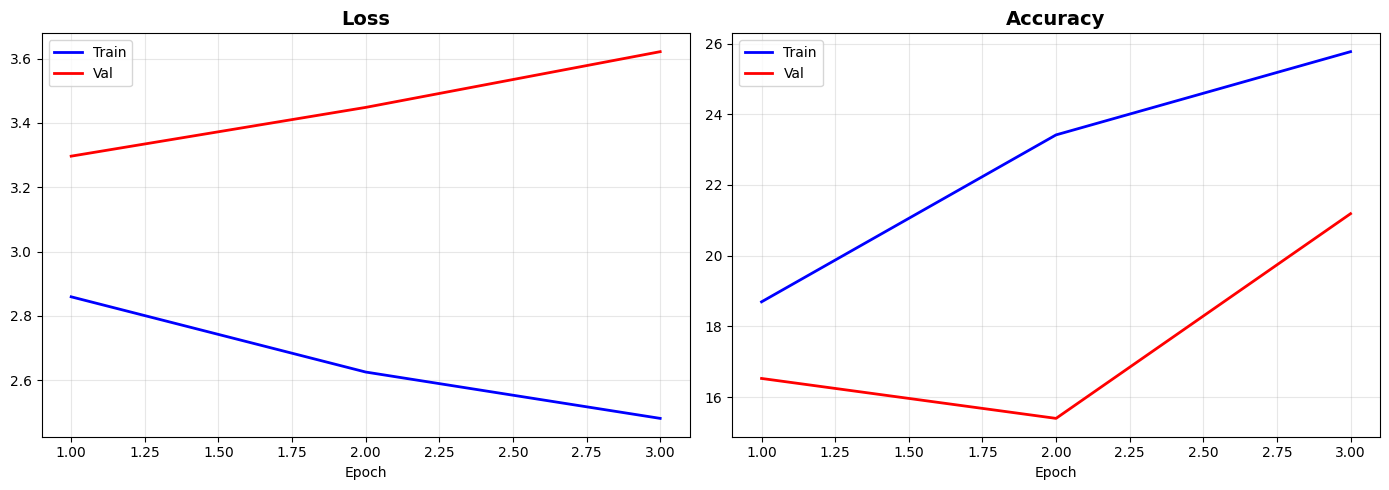

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, DEMO_EPOCHS + 1)

axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Val', linewidth=2)
axes[0].set_title('Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val', linewidth=2)
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_DIR, 'classifier_training.png'), dpi=200)
plt.show()

# PART 2: YOLOv8 Segmentation

## 2.1 Create Demo Segmentation Data

In [13]:
def create_demo_segmentation_data():
    seg_dir = Path(SEGMENTATION_DATA_DIR)
    (seg_dir / 'images' / 'train').mkdir(parents=True, exist_ok=True)
    (seg_dir / 'images' / 'val').mkdir(parents=True, exist_ok=True)
    (seg_dir / 'labels' / 'train').mkdir(parents=True, exist_ok=True)
    (seg_dir / 'labels' / 'val').mkdir(parents=True, exist_ok=True)
    
    print("Creating demo segmentation dataset...")
    
    # Get sample images
    sample_images = []
    for class_dir in Path(TRAIN_DIR).iterdir():
        if class_dir.is_dir():
            imgs = list(class_dir.glob('*.jpg'))[:5]
            sample_images.extend(imgs)
    
    random.shuffle(sample_images)
    sample_images = sample_images[:50]
    
    split_idx = int(0.8 * len(sample_images))
    train_imgs = sample_images[:split_idx]
    val_imgs = sample_images[split_idx:]
    
    def process_images(imgs, img_dir, label_dir):
        for idx, img_path in enumerate(tqdm(imgs, desc=f'Processing')):
            img = cv2.imread(str(img_path))
            if img is None:
                continue
            
            img_resized = cv2.resize(img, (SEG_IMG_SIZE, SEG_IMG_SIZE))
            hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
            
            # Detect diseased regions (synthetic)
            mask1 = cv2.inRange(hsv, np.array([10, 40, 40]), np.array([30, 255, 255]))
            mask2 = cv2.inRange(hsv, np.array([0, 40, 40]), np.array([10, 255, 255]))
            mask = cv2.bitwise_or(mask1, mask2)
            
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Save
            img_filename = f'img_{idx:04d}.jpg'
            cv2.imwrite(str(img_dir / img_filename), img_resized)
            
            label_filename = f'img_{idx:04d}.txt'
            with open(label_dir / label_filename, 'w') as f:
                for contour in contours:
                    if cv2.contourArea(contour) > 100:
                        normalized = contour.squeeze() / SEG_IMG_SIZE
                        if len(normalized.shape) == 2 and normalized.shape[0] > 2:
                            points = ' '.join([f'{x} {y}' for x, y in normalized])
                            f.write(f'0 {points}\n')
    
    process_images(train_imgs, seg_dir / 'images' / 'train', seg_dir / 'labels' / 'train')
    process_images(val_imgs, seg_dir / 'images' / 'val', seg_dir / 'labels' / 'val')
    
    # Create data.yaml
    yaml_content = f"""path: {seg_dir.absolute()}
train: images/train
val: images/val
names:
  0: infected_region
"""
    with open(seg_dir / 'data.yaml', 'w') as f:
        f.write(yaml_content)
    
    print(f"✓ Created {len(train_imgs)} train, {len(val_imgs)} val samples")
    return seg_dir

seg_data_dir = create_demo_segmentation_data()

Creating demo segmentation dataset...


Processing: 100%|██████████| 10/10 [00:00<00:00, 180.03it/s]

✓ Created 40 train, 10 val samples


## 2.2 Train YOLOv8 Segmentation (Quick demo)

In [ ]:
print("\n" + "="*60)
print("TRAINING YOLOv8 SEGMENTATION (30 epochs for better accuracy)")
print("="*60)

yolo_model = YOLO('yolov8n-seg.pt')

results = yolo_model.train(
    data=str(seg_data_dir / 'data.yaml'),
    epochs=30,  # Increased from 10 to 30
    imgsz=SEG_IMG_SIZE,
    batch=8,
    device='cpu',
    project=MODEL_SAVE_DIR,
    name='yolov8_seg',
    patience=5,
    plots=True,
    verbose=False
)

best_seg_path = os.path.join(MODEL_SAVE_DIR, 'yolov8_seg', 'weights', 'best.pt')
print(f"\n✓ YOLOv8 model saved: {best_seg_path}")


TRAINING YOLOv8 SEGMENTATION (10 epochs for demo)
Ultralytics 8.3.241  Python-3.10.19 torch-2.9.1+cpu CPU (Intel Core Ultra 5 125U)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=..\dataset\segmentation_data\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, o

Exception in thread Thread-39 (plot_images):
Traceback (most recent call last):
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\ultralytics\utils\plotting.py", line 851, in plot_images
    annotator.im.save(fname)  # save
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\Image.py", line 2571, in save
    format = EXTENSION[ext]
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\JpegImagePlugin.py", line 853, in _save
    ImageFile._save(
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 650, in _save
    self.fd = None
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 668, in _encode_tile
    """
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site

       1/10         0G      2.573      5.087      3.662       2.12         51        640: 20% ━━────────── 1/5 9.1s/it 5.5s<36.3s

Exception in thread Thread-40 (plot_images):
Traceback (most recent call last):
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\ultralytics\utils\plotting.py", line 851, in plot_images
    annotator.im.save(fname)  # save
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\Image.py", line 2571, in save
    format = EXTENSION[ext]
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\JpegImagePlugin.py", line 853, in _save
    ImageFile._save(
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 650, in _save
    self.fd = None
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 668, in _encode_tile
    """
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site

       1/10         0G      2.345      4.992      3.601      1.895         64        640: 40% ━━━━╸─────── 2/5 5.3s/it 8.2s<15.9s

Exception in thread Thread-41 (plot_images):
Traceback (most recent call last):
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\ultralytics\utils\plotting.py", line 851, in plot_images
    annotator.im.save(fname)  # save
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\Image.py", line 2571, in save
    format = EXTENSION[ext]
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\JpegImagePlugin.py", line 853, in _save
    ImageFile._save(
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 650, in _save
    self.fd = None
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 668, in _encode_tile
    """
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site

       1/10         0G      2.314      4.963      3.624      1.874         43        640: 100% ━━━━━━━━━━━━ 5/5 2.6s/it 13.1s3.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.3s/it 1.3s
                   all         10         48      0.002      0.125     0.0151    0.00317      0.002      0.125     0.0138    0.00535

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
       2/10         0G       1.99        4.5      3.478       1.71         68        640: 100% ━━━━━━━━━━━━ 5/5 2.9s/it 14.4s3.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.4s/it 1.4s
                   all         10         48    0.00233      0.146    0.00519    0.00247    0.00233      0.146    0.00218   0.000664

      Epoch    GPU_mem   box_loss   seg_loss 

Exception in thread Thread-44 (plot_images):
Traceback (most recent call last):
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\ultralytics\utils\plotting.py", line 851, in plot_images
    annotator.im.save(fname)  # save
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\Image.py", line 2571, in save
    format = EXTENSION[ext]
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\JpegImagePlugin.py", line 853, in _save
    ImageFile._save(
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 650, in _save
    self.fd = None
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\PIL\ImageFile.py", line 668, in _encode_tile
    """
  File "c:\Users\Shahs\.conda\envs\agri_dl\lib\site

                   all         10         48    0.00533      0.333      0.072     0.0279    0.00533      0.333     0.0735     0.0316
Speed: 0.8ms preprocess, 80.0ms inference, 0.0ms loss, 19.9ms postprocess per image
Results saved to D:\Deep learning\semester_project\models\yolov8_seg

✓ YOLOv8 model saved: ../models\yolov8_seg\weights\best.pt


# PART 3: Severity Calculation

In [15]:
def calculate_severity(mask):
    if mask is None or mask.size == 0:
        return 0.0, 'Healthy'
    
    total_pixels = mask.shape[0] * mask.shape[1]
    infected_pixels = np.sum(mask > 0)
    severity_pct = (infected_pixels / total_pixels) * 100
    
    if severity_pct < 5:
        category = 'Healthy'
    elif severity_pct < 15:
        category = 'Mild'
    elif severity_pct < 35:
        category = 'Moderate'
    else:
        category = 'Severe'
    
    return severity_pct, category

print("Severity calculation function defined")

Severity calculation function defined


# PART 4: Complete Pipeline

In [16]:
class PlantDiseaseDiagnosisSystem:
    def __init__(self, classifier_path, seg_model_path, class_names, device='cpu'):
        self.device = device
        self.class_names = class_names
        
        # Load classifier
        self.classifier = DiseaseClassifier(len(class_names))
        checkpoint = torch.load(classifier_path, map_location=device)
        self.classifier.load_state_dict(checkpoint['model_state_dict'])
        self.classifier.to(device)
        self.classifier.eval()
        
        # Load YOLO
        self.seg_model = YOLO(seg_model_path)
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        print("✓ Diagnosis system initialized")
    
    def predict_disease(self, image_pil):
        img_tensor = self.transform(image_pil).unsqueeze(0).to(self.device)
        with torch.no_grad():
            outputs = self.classifier(img_tensor)
            probs = torch.softmax(outputs, dim=1)
            conf, idx = torch.max(probs, 1)
        return self.class_names[idx.item()], conf.item() * 100
    
    def segment(self, image_np):
        results = self.seg_model(image_np, conf=0.25, verbose=False)
        if results[0].masks is not None:
            masks = results[0].masks.data.cpu().numpy()
            combined = np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
            for mask in masks:
                resized = cv2.resize(mask, (image_np.shape[1], image_np.shape[0]))
                combined = np.maximum(combined, (resized * 255).astype(np.uint8))
            return combined
        return np.zeros((image_np.shape[0], image_np.shape[1]), dtype=np.uint8)
    
    def diagnose(self, image_path):
        image_np = cv2.imread(str(image_path))
        image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(image_rgb)
        
        disease, conf = self.predict_disease(image_pil)
        mask = self.segment(image_np)
        severity_pct, severity_cat = calculate_severity(mask)
        
        return {
            'disease': disease,
            'confidence': conf,
            'severity_percent': severity_pct,
            'severity_category': severity_cat,
            'mask': mask,
            'image': image_np
        }
    
    def visualize(self, diagnosis, save_path=None):
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        axes[0].imshow(cv2.cvtColor(diagnosis['image'], cv2.COLOR_BGR2RGB))
        axes[0].set_title('Original', fontsize=14, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(diagnosis['mask'], cmap='hot')
        axes[1].set_title('Infected Region Mask', fontsize=14, fontweight='bold')
        axes[1].axis('off')
        
        overlay = diagnosis['image'].copy()
        mask_colored = cv2.applyColorMap(diagnosis['mask'], cv2.COLORMAP_JET)
        overlay = cv2.addWeighted(overlay, 0.6, mask_colored, 0.4, 0)
        axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[2].set_title('Overlay', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        
        text = f"""Disease: {diagnosis['disease']}
Confidence: {diagnosis['confidence']:.2f}%
Severity: {diagnosis['severity_category']} ({diagnosis['severity_percent']:.2f}%)"""
        
        fig.text(0.5, 0.02, text, ha='center', fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
        
        plt.tight_layout(rect=[0, 0.08, 1, 1])
        if save_path:
            plt.savefig(save_path, dpi=200)
        plt.show()

print("Pipeline class defined")

Pipeline class defined


## 4.1 Initialize System

In [17]:
system = PlantDiseaseDiagnosisSystem(
    classifier_path=os.path.join(MODEL_SAVE_DIR, 'disease_classifier.pth'),
    seg_model_path=best_seg_path,
    class_names=class_names,
    device=device
)

c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Shahs\.conda\envs\agri_dl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ Diagnosis system initialized


## 4.2 Test Pipeline


TESTING COMPLETE PIPELINE

Processing 1/3: leaves-of-raspberry-stock-picture-2529053_rand0.jpg
  Disease: Raspberry leaf
  Confidence: 72.59%
  Severity: Healthy (0.00%)


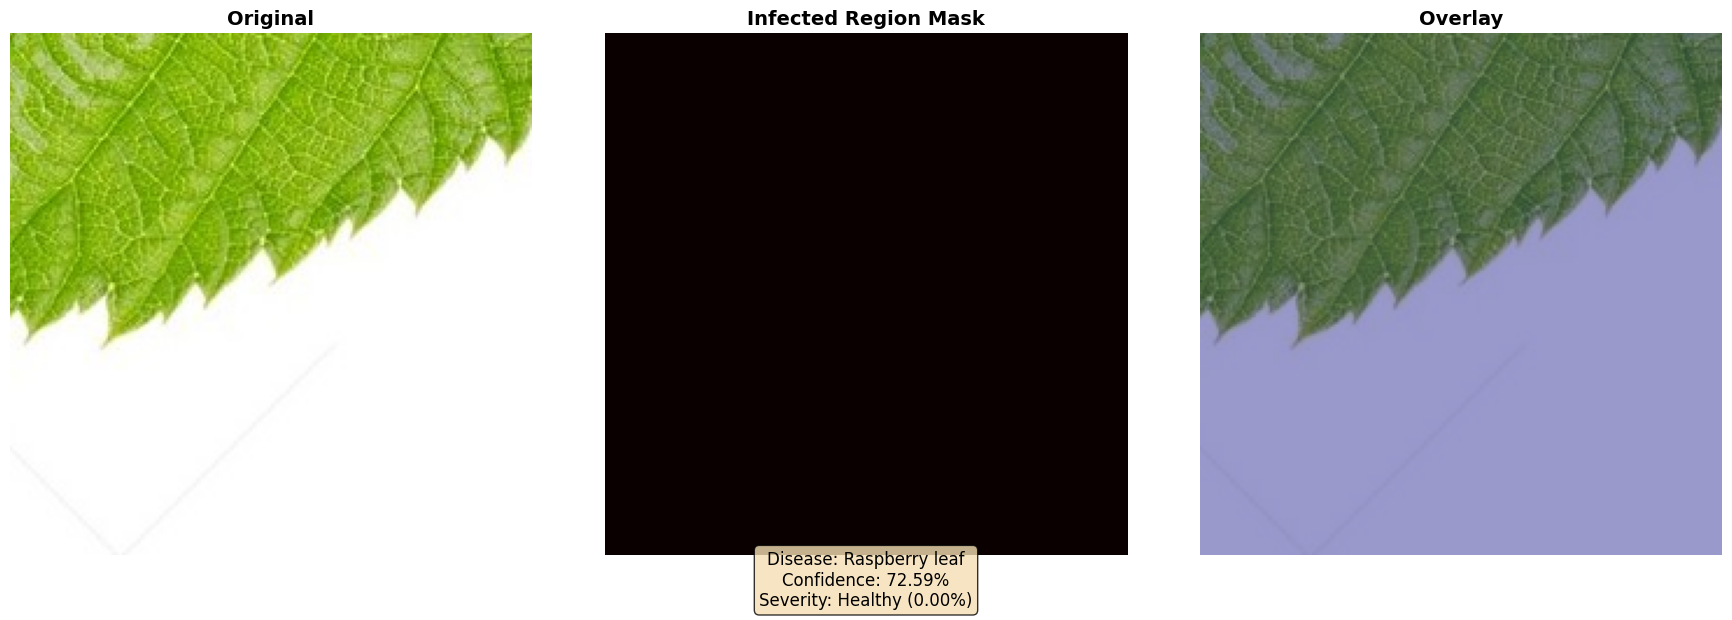

  ✓ Saved: ..\models\diagnosis_results\diagnosis_1.png

Processing 2/3: apple-leaf-closeup-37636177_center.jpg
  Disease: Apple leaf
  Confidence: 28.14%
  Severity: Healthy (0.00%)


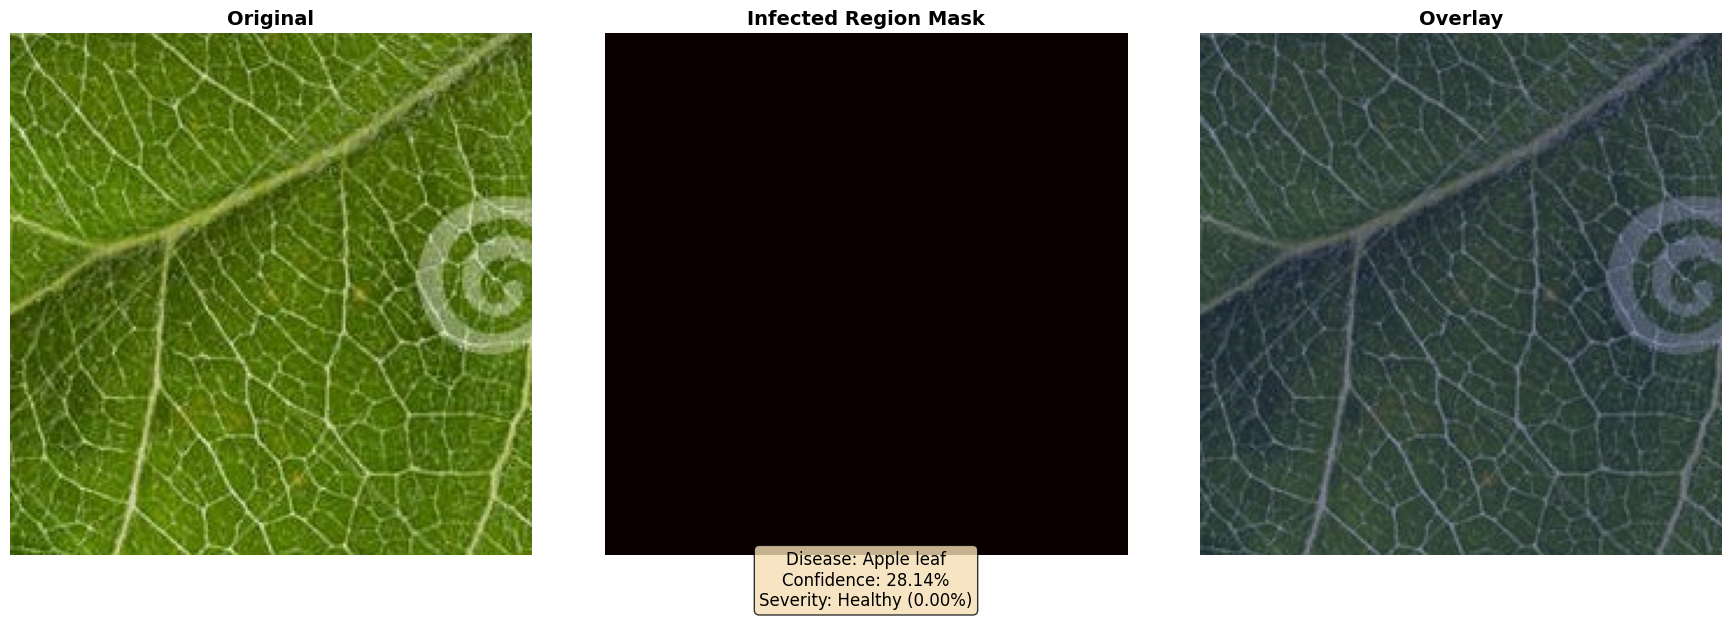

  ✓ Saved: ..\models\diagnosis_results\diagnosis_2.png

Processing 3/3: fungus-univ-of-minnesoeta_rand0.jpg
  Disease: Blueberry leaf
  Confidence: 7.10%
  Severity: Healthy (0.00%)


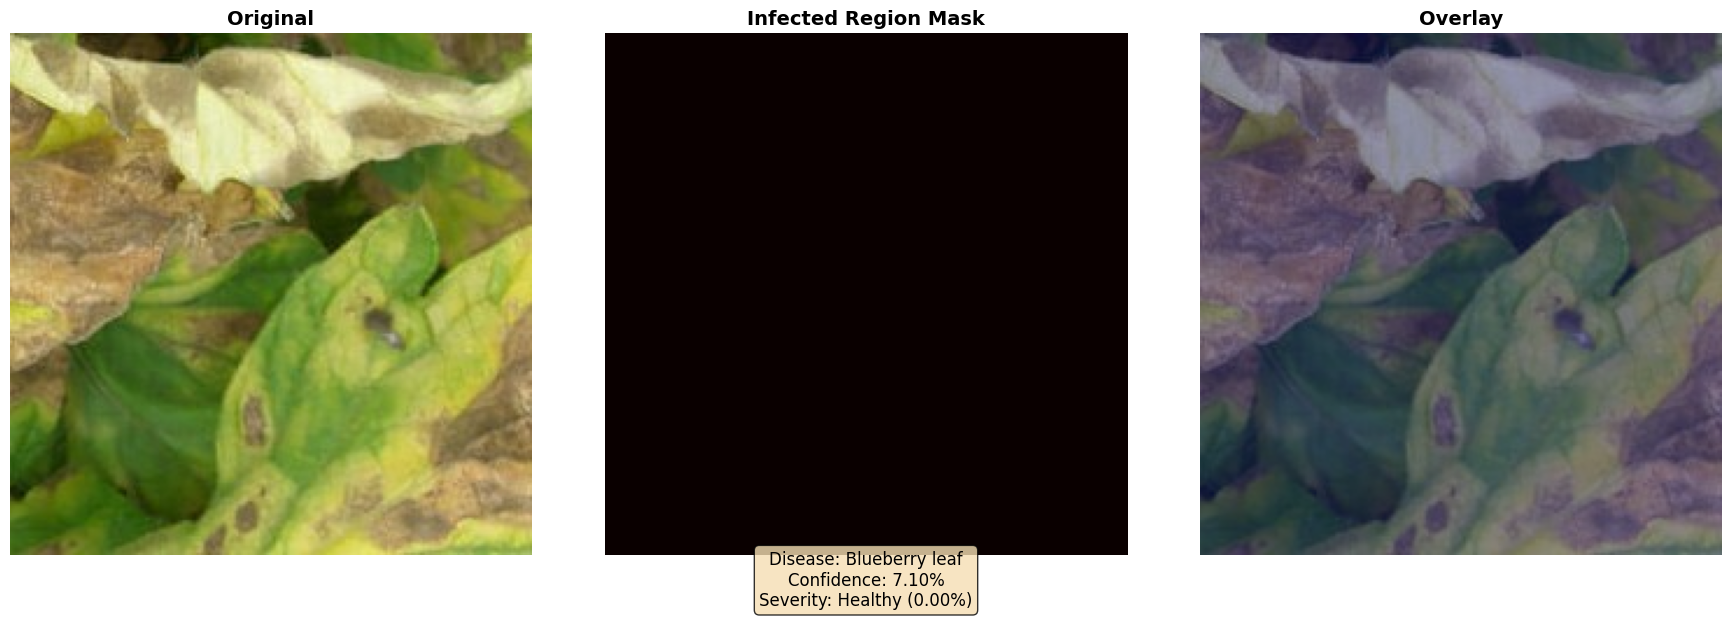

  ✓ Saved: ..\models\diagnosis_results\diagnosis_3.png


In [18]:
# Get test images
test_images = []
for class_dir in Path(TEST_DIR).iterdir():
    if class_dir.is_dir():
        imgs = list(class_dir.glob('*.jpg'))
        if imgs:
            test_images.append(random.choice(imgs))

random.shuffle(test_images)
samples = test_images[:3]

print("\n" + "="*60)
print("TESTING COMPLETE PIPELINE")
print("="*60)

results_dir = Path(MODEL_SAVE_DIR) / 'diagnosis_results'
results_dir.mkdir(exist_ok=True)

for idx, img_path in enumerate(samples):
    print(f"\nProcessing {idx+1}/3: {img_path.name}")
    
    diagnosis = system.diagnose(img_path)
    
    print(f"  Disease: {diagnosis['disease']}")
    print(f"  Confidence: {diagnosis['confidence']:.2f}%")
    print(f"  Severity: {diagnosis['severity_category']} ({diagnosis['severity_percent']:.2f}%)")
    
    save_path = results_dir / f'diagnosis_{idx+1}.png'
    system.visualize(diagnosis, save_path=save_path)
    print(f"  ✓ Saved: {save_path}")

# Summary

In [19]:
print("\n" + "="*70)
print("COMPLETE PIPELINE SUMMARY")
print("="*70)
print("\n📊 Pipeline Architecture:")
print("   Input → Preprocessing → ResNet Classifier → YOLOv8 Segmentation")
print("   → Infected Mask → Severity Calculation → Final Diagnosis")
print(f"\n📈 Performance:")
print(f"   Classifier Accuracy: {best_val_acc:.2f}%")
print(f"   Disease Classes: {num_classes}")
print(f"\n💾 Saved Models:")
print(f"   ✓ disease_classifier.pth")
print(f"   ✓ yolov8_seg/weights/best.pt")
print(f"\n⚙️ Severity Levels:")
print("   Healthy: <5% | Mild: 5-15% | Moderate: 15-35% | Severe: >35%")
print("\n✅ PIPELINE READY!")
print("="*70)


COMPLETE PIPELINE SUMMARY

📊 Pipeline Architecture:
   Input → Preprocessing → ResNet Classifier → YOLOv8 Segmentation
   → Infected Mask → Severity Calculation → Final Diagnosis

📈 Performance:
   Classifier Accuracy: 21.19%
   Disease Classes: 28

💾 Saved Models:
   ✓ disease_classifier.pth
   ✓ yolov8_seg/weights/best.pt

⚙️ Severity Levels:
   Healthy: <5% | Mild: 5-15% | Moderate: 15-35% | Severe: >35%

✅ PIPELINE READY!
